### **TP 2 - Détection de menaces radar**

Cours d'*apprentissage profond et traitemet du signal MVA*

Auteurs: 
- *Naïl Khelifa*
- *Quentin Moayedpour*

In [4]:
#!pip install numpy
#!pip install sklearn
#!pip install pathlib 

In [14]:
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import scipy

In [15]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")





<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br> 
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [16]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

<div class=consignes> et les fichiers d'annotations:</div>

In [17]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)
nonmenace_train, menace_train = [], []

for key, values in dict_labels.items():
    if values == 'nonmenace':
        nonmenace_train.append(key)
    else:
        menace_train.append(key)

<div class=consignes> On compte sur vous, bonne chance ! </div>

## 1. **Travail sur les données**

En observant les données, on se rend compte que l'échantillonnage n'est pas régulier ce qui complique le travail pour celles-ci. Pour remédier à ce problème, on se propose de réechantillonner le tout, avec une **fréquence d'échantillonnage** de 10 Hz.

On commence par définir la fonction `data_transformation` qui effectue ces transformations sur les données 

In [52]:
def data_transformation(source="train", sample_count=200) -> pd.DataFrame:
    """Normalizes and standardizes the dataset.
    
    Parameters:
    - source (str): The source dataset. Default is "train_set".
    - sample_count (int): Number of samples for the regular timeline. Default is 200.
    
    Returns:
    pd.DataFrame: A DataFrame with the standardized dataset.
    """
    records = []  # List to store transformed records
    measurement_units = [  # Measurement units and their scale factors
        ("largeur", 1.E-3),
        ("frequence", 1.E9),
        ("puissance", 1.), 
        ("theta", 1.),
        ("phi", 1.)
    ]
    
    # Open the JSON file containing labels associated with the data
    with open('./radars/' + f'{source}_labels.json') as file:
        dict_labels = json.load(file)  # Load labels into a dictionary

    # Loop through each data point (800 points in the test set)
    for index in range(800):
        # Load data from an .npz file
        data_points = np.load('./radars/' + source + f'/pdw-{index}.npz')
        
        # Check if the data point is considered non-threatening
        is_non_threat = dict_labels[f'pdw-{index}'] == "nonmenace"
        
        # Retrieve timestamps
        timestamps = data_points['date']
        
        # Create a regular timeline with the specified sample count
        uniform_times = np.linspace(0, 10.E3, sample_count)
        record = {}  # Dictionary to store transformed values for this point

        # Normalize the values of each measurement
        for measurement, scale in measurement_units:
            non_uniform_values = data_points[measurement]  # Non-uniform values
            # Interpolate to get sampled values on the regular timeline
            resampled_values = np.interp(uniform_times, xp=timestamps, fp=non_uniform_values)
            record[measurement] = resampled_values * scale  # Apply scale factor

        # Indicate whether the point is threatening or not in the record
        record["menace"] = not is_non_threat
        
        # Calculate time intervals between timestamps
        time_intervals = (timestamps[1:] - timestamps[:-1]) / 1000.  # Convert to seconds
        # Calculate the ratio of time intervals relative to the smallest interval
        record["time_intervals_ratio"] = np.round(time_intervals / np.min(time_intervals))
        # Calculate impulse frequency
        record["impulse_frequency"] = 1. / np.min(time_intervals)

        # Calculate max, min, and standard deviation of frequency
        record["max_frequency"] = np.max(data_points['frequence'])
        record["min_frequency"] = np.min(data_points['frequence'])
        record["std_frequency"] = np.std(data_points['frequence'])

        records.append(record)  # Add the transformed record to the list

    # Conversion of the list of records to DataFrame
    standardized_df = pd.DataFrame.from_dict(records)
    return standardized_df

def identify_peaks(data_frame, include_in_df):
    """
    Identifies peaks in the 'puissance' column of the given DataFrame.
    
    Parameters:
    data_frame (pd.DataFrame): The DataFrame containing data to analyze.
    include_in_df (bool): If True, adds the locations and values of the peaks to the DataFrame. Default is False.
    
    Returns:
    Tuple[List, List]: A tuple containing two lists:
                       - List of peak locations for each signal.
                       - List of peak values for each signal.
    """
    # Iterate over two cases: find peaks above and below a certain threshold
    for is_below_threshold, label_prefix in [(True, "below_"), (False, "")]:
        peak_indices_list = []  # To store indices of detected peaks
        peak_values_list = []   # To store values of detected peaks

        # Iterate over each row of the DataFrame
        for index in range(len(data_frame)):
            # Find peaks in the 'puissance' column, inverting the signal for the below-threshold case
            peaks = scipy.signal.find_peaks((-1 if is_below_threshold else 1.) * data_frame['puissance'][index])[0]
            peak_indices_list.append(peaks)  # Add the indices of the peaks
            peak_values_list.append(data_frame['puissance'][index][peaks])  # Add the corresponding peak values

        # If requested, add the locations and values of the peaks to the DataFrame
        if include_in_df:
            data_frame[label_prefix + "peak_indices"] = peak_indices_list
            data_frame[label_prefix + "peak_values"] = peak_values_list

    return peak_indices_list, peak_values_list  # Return lists of indices and values of the peaks


In [53]:
df_train = data_transformation(source="train")
df_test = data_transformation(source="test")
identify_peaks(data_frame=df_train, include_in_df=True)
identify_peaks(data_frame=df_test, include_in_df=True)
df_train.head()

,largeur,frequence,puissance,theta,phi,menace,time_intervals_ratio,impulse_frequency,max_frequency,min_frequency,std_frequency,below_peak_indices,below_peak_values,peak_indices,peak_values
0,"[0.00029099999999999997, 0.0002925462967097541...","[2222011346.301772, 2210190174.161303, 2201408...","[-125.58248735699023, -137.73117286822165, -11...","[0.9578859532471261, 0.7343339379117413, 0.866...","[1.678935775441994, 1.455705735798324, 1.72172...",False,"[16.0, 8.0, 20.0, 26.0, 12.0, 1.0, 26.0, 4.0, ...",677.048070,2.238800,2.178543,0.008909,"[1, 6, 8, 11, 13, 17, 23, 29, 38, 47, 56, 65, ...","[-137.73117286822165, -136.89213047447032, -13...","[4, 7, 9, 12, 15, 20, 25, 33, 43, 51, 61, 69, ...","[-108.22692681699502, -120.32274165415004, -12..."
1,"[0.00013800000000000002, 0.0001375009186117503...","[3011221070.570557, 3005833673.142144, 2996036...","[-127.176799666022, -131.25959573340265, -157....","[2.7962717807754327, -2.86707067085857, -2.833...","[1.5296932038533972, 1.2996998872300567, 1.555...",False,"[17.0, 6.0, 7.0, 10.0, 2.0, 35.0, 25.0, 55.0, ...",1092.896175,3.031234,2.946963,0.012328,"[3, 16, 19, 33, 46, 53, 59, 70, 77, 85, 98, 11...","[-167.92745235056768, -170.25133630502825, -17...","[6, 17, 26, 40, 52, 54, 69, 72, 78, 91, 103, 1...","[-134.28790793692875, -153.53343069162545, -14..."
2,"[0.000201, 0.00020109414761095855, 0.000201870...","[991990464.3038368, 982416900.4205706, 9827406...","[-149.880060930416, -151.50575468873052, -151....","[-2.0412578355641227, -2.2484651512810436, -1....","[1.6722396416013094, 1.6546040793964472, 1.774...",True,"[15.0, 5.0, 3.0, 1.0, 2.0, 41.0, 1.0, 20.0, 13...",634.517766,0.997647,0.972759,0.004003,"[10, 19, 27, 34, 41, 48, 56, 63, 70, 77, 84, 9...","[-182.71836508960047, -192.36040777446118, -18...","[15, 22, 30, 38, 45, 52, 60, 66, 74, 80, 88, 9...","[-159.58968698641334, -163.24498482179453, -16..."
3,"[6.800000000000001e-05, 6.96985671972421e-05, ...","[1666424017.2021985, 1666884113.1552737, 16679...","[-135.68775777002037, -134.2389708763986, -134...","[-2.621701006244045, -2.3214001334485976, -2.2...","[1.4039557266900524, 1.589896356959997, 1.6206...",False,"[16.0, 3.0, 2.0, 2.0, 8.0, 15.0, 6.0, 23.0, 10...",1466.275660,1.691682,1.640058,0.006610,"[2, 10, 12, 14, 16, 21, 31, 40, 46, 55, 75, 82...","[-134.57254005151339, -138.75265139770625, -13...","[1, 3, 11, 13, 15, 17, 22, 39, 44, 47, 63, 81,...","[-134.2389708763986, -134.150552722059, -138.7..."
4,"[0.000324, 0.000324, 0.0003247910207412382, 0....","[2207809393.1871147, 2193501112.731577, 220070...","[-172.60362010919195, -161.3296111640187, -151...","[2.274032092616462, 2.2832470272512277, 2.1258...","[1.6134753329852611, 1.217755019835661, 1.5970...",False,"[17.0, 1.0, 4.0, 5.0, 25.0, 27.0, 1.0, 21.0, 2...",604.960678,2.229983,2.182394,0.008529,"[4, 6, 9, 12, 20, 22, 26, 41, 61, 67, 77, 87, ...","[-154.0989707205061, -158.58696528361452, -167...","[3, 5, 8, 10, 14, 21, 23, 27, 50, 64, 76, 78, ...","[-149.80587798867748, -149.95418374512565, -15..."


## 2. **Visualisation des données et recherche des features pertinentes**

     Feature  Explained Variance
0    largeur            0.380753
1  frequence            0.339824
2  puissance            0.279423


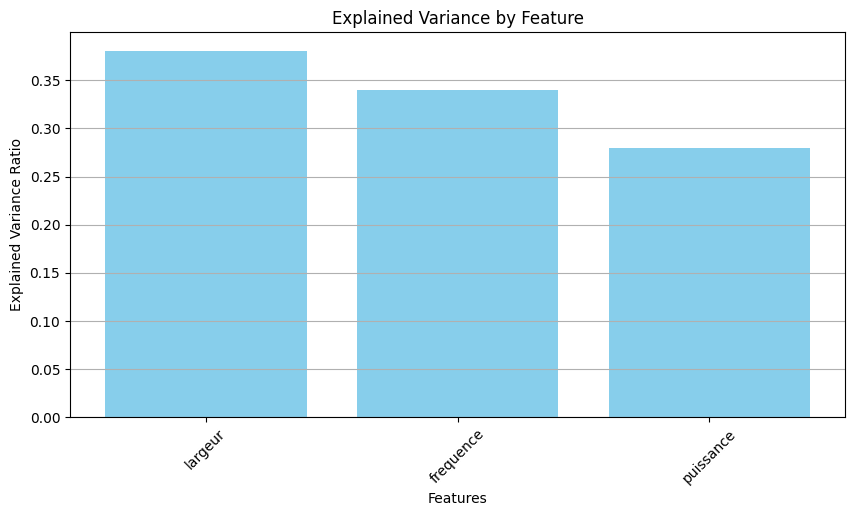

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Prepare the data for SVD
X = np.array([np.mean(df_train['largeur'].values.tolist(), axis=1),
              np.mean(df_train['frequence'].values.tolist(), axis=1),
              np.mean(df_train['puissance'].values.tolist(), axis=1)]).T

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform SVD
U, S, VT = np.linalg.svd(X_scaled, full_matrices=False)

# Calculate explained variance
explained_variance = (S**2) / np.sum(S**2)

# Create a DataFrame to associate features with their explained variance
features = ['largeur', 'frequence', 'puissance']
explained_variance_df = pd.DataFrame({
    'Feature': features,
    'Explained Variance': explained_variance[:len(features)]
})

# Sort the DataFrame by explained variance
explained_variance_df.sort_values(by='Explained Variance', ascending=False, inplace=True)

# Display the sorted explained variance
print(explained_variance_df)

# Visualization of Explained Variance
plt.figure(figsize=(10, 5))
plt.bar(explained_variance_df['Feature'], explained_variance_df['Explained Variance'], color='skyblue')
plt.title('Explained Variance by Feature')
plt.xlabel('Features')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_78263/274710529.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dataset', y=var, data=df_combined, palette=['skyblue', 'salmon'])
/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_78263/274710529.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dataset', y=var, data=df_combined, palette=['skyblue', 'salmon'])
/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_78263/274710529.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dataset', y=var, data=

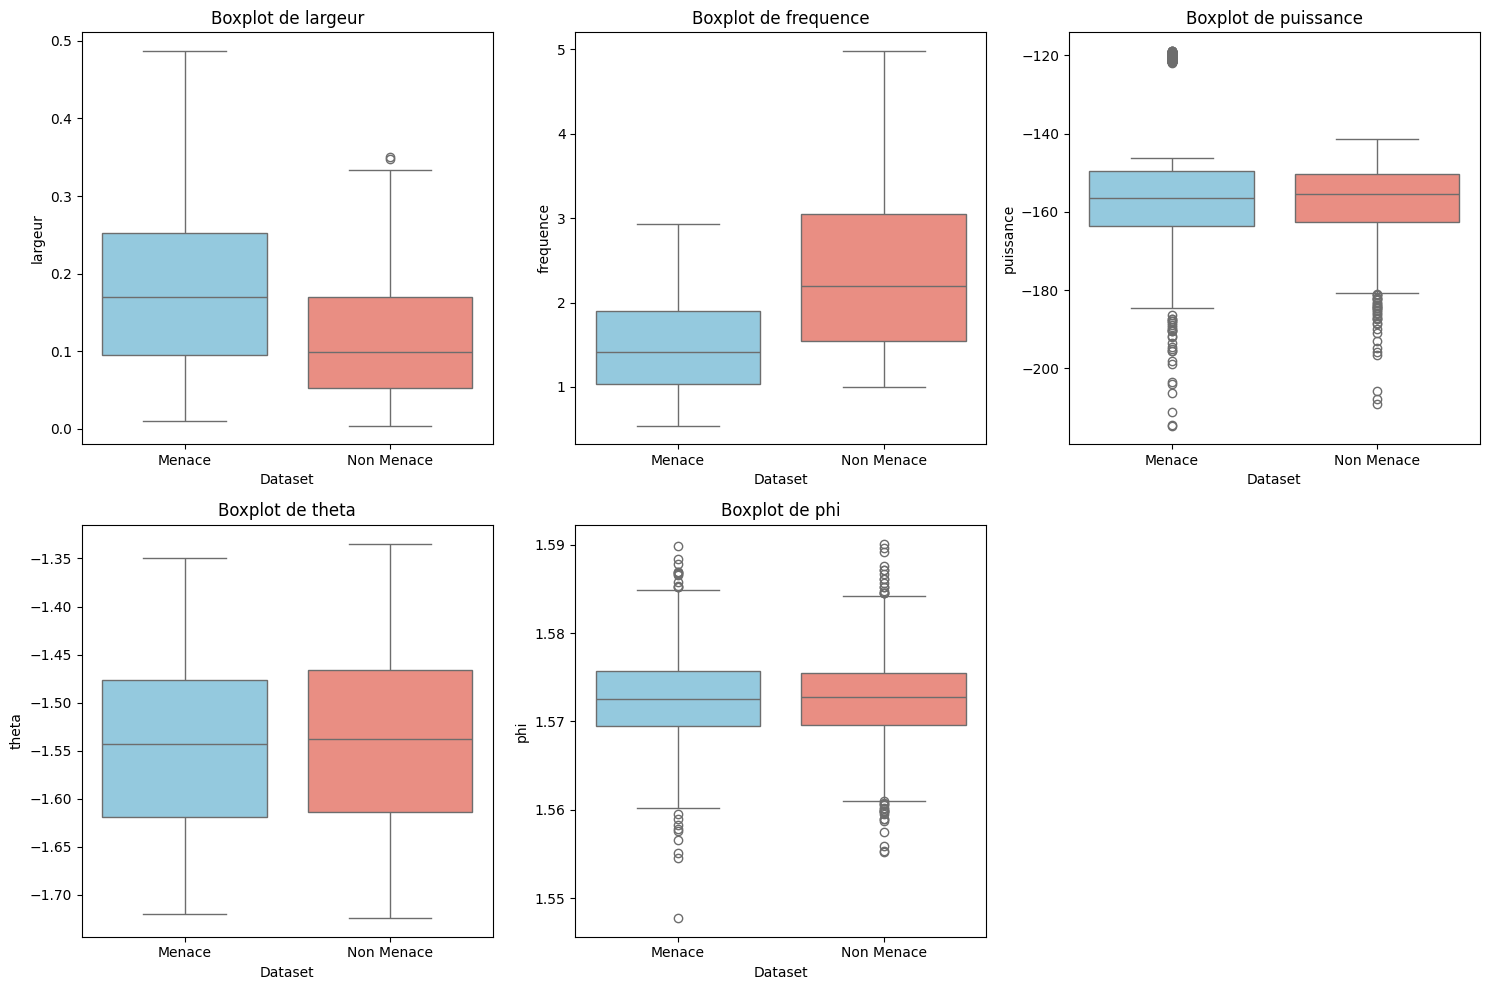

In [69]:
# Ajouter une colonne pour identifier le dataset
menace_avg_values['dataset'] = 'Menace'
nonmenace_avg_values['dataset'] = 'Non Menace'

# Combiner les deux datasets
df_combined = pd.concat([menace_avg_values, nonmenace_avg_values], ignore_index=True)

# Variables à tracer
variables = ['largeur', 'frequence', 'puissance', 'theta', 'phi']

# Tracer les boxplots
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 3, i+1)  # Deux lignes, trois colonnes
    sns.boxplot(x='dataset', y=var, data=df_combined, palette=['skyblue', 'salmon'])
    plt.title(f'Boxplot de {var}')
    plt.ylabel(var)
    plt.xlabel('Dataset')

plt.tight_layout()
plt.show()

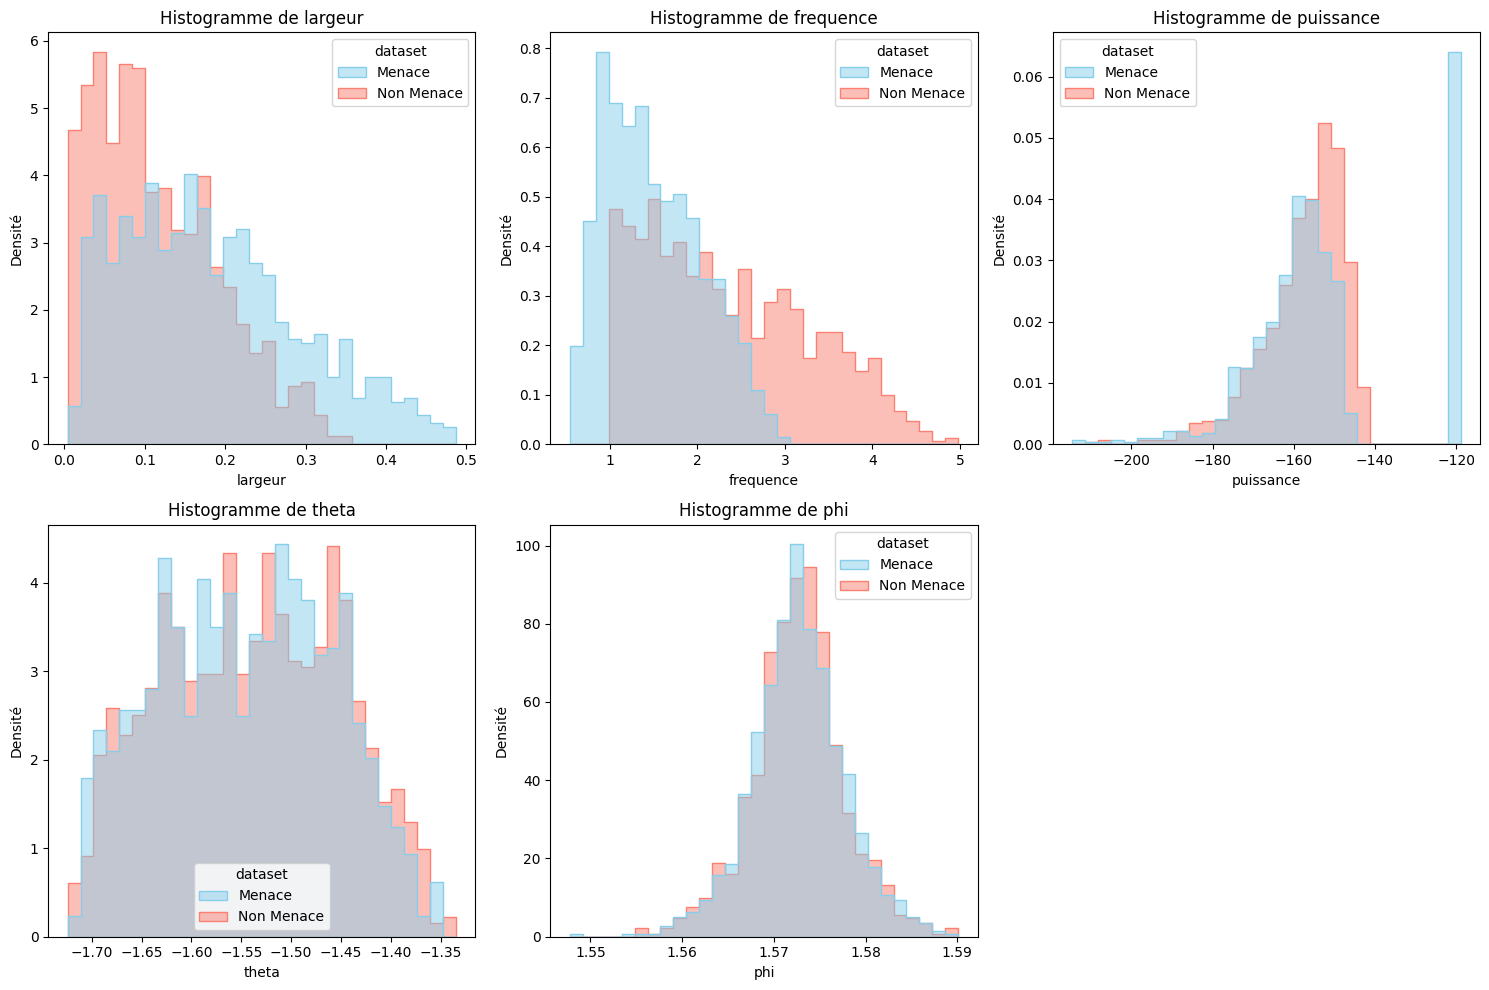

In [71]:
# Tracer les histograms
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 3, i + 1)  # Deux lignes, trois colonnes
    sns.histplot(data=df_combined, x=var, hue='dataset', element='step', stat='density', common_norm=False, 
                 palette=['skyblue', 'salmon'], bins=30, alpha=0.5)
    plt.title(f'Histogramme de {var}')
    plt.ylabel('Densité')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

On choisit largeur et fréquence pour entraîner 2 algos

#### Régression logistique selon la variable **fréquence**

In [121]:
# Préparation des données
X_freq = df_combined[['frequence']]  
X_largeur = df_combined[['largeur']] 
y = df_combined['dataset'].map({'Menace': 1, 'Non Menace': 0})  # Variable cible

model_freq = LogisticRegression()
model_largeur = LogisticRegression()

model_freq.fit(X_freq, y)
model_largeur.fit(X_largeur, y)

LogisticRegression()

On importe le fichier d'annotation de test

In [122]:
with open('./radars/test_labels.json') as f: 
    dict_labels_test = json.load(f)

et celui des signaux de test

In [123]:
data_test = []

for i in range(800):
    path = f'./radars/test/pdw-{i}.npz'
    pdws = np.load(path)
    data_test.append({
        'date': pdws['date'],
        'largeur': pdws['largeur'],
        'frequence': pdws['frequence'],
        'puissance': pdws['puissance'],
        'theta': pdws['theta'],
        'phi': pdws['phi']
    })


data_test = pd.DataFrame(data_test)

In [124]:
avg_values_test = {}
features = ['largeur', 'frequence', 'puissance', 'theta', 'phi']

for feature in features:
    avg_values_test[feature] = data_test[feature].apply(np.mean)

avg_values_test = pd.DataFrame(avg_values_test)

In [125]:
# Faire les prédictions
freq_pred = model_freq.predict(avg_values_test["frequence"].values.reshape(-1, 1))
largeur_pred = model_largeur.predict(avg_values_test["largeur"].values.reshape(-1, 1))

# Convertir les résultats en une Series de Pandas
freq_pred = pd.Series(freq_pred).map({1: 'menace', 0: 'nonmenace'})
largeur_pred = pd.Series(largeur_pred).map({1: 'menace', 0: 'nonmenace'})

# On stocke les vrais labels de test
y_ground_truth = pd.Series(dict_labels_test.values())

/Users/badis/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/badis/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


On évalue la performance de notre algorithme naïf qui prédit selon la fréquence

## **Bayes naïf**

In [133]:
from sklearn.naive_bayes import GaussianNB

## **Régression logistique**

Rapport de Classification pour la variable 'frequence':
              precision    recall  f1-score   support

   nonmenace       0.66      0.73      0.69       385
      menace       0.72      0.66      0.69       415

    accuracy                           0.69       800
   macro avg       0.69      0.69      0.69       800
weighted avg       0.69      0.69      0.69       800



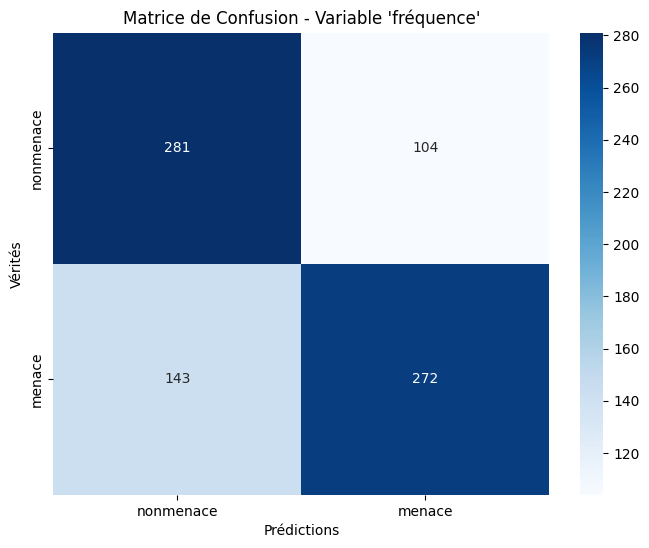

In [126]:
# Afficher le rapport de classification
print("Rapport de Classification pour la variable 'frequence':")
print(classification_report(y_ground_truth, freq_pred, target_names=['nonmenace', 'menace']))

# Calculer la matrice de confusion
cm = confusion_matrix(y_ground_truth, freq_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nonmenace', 'menace'], yticklabels=['nonmenace', 'menace'])
plt.title("Matrice de Confusion - Variable 'fréquence'")
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

Rapport de Classification pour la variable 'largeur':
              precision    recall  f1-score   support

   nonmenace       0.64      0.54      0.58       385
      menace       0.63      0.72      0.67       415

    accuracy                           0.63       800
   macro avg       0.63      0.63      0.63       800
weighted avg       0.63      0.63      0.63       800



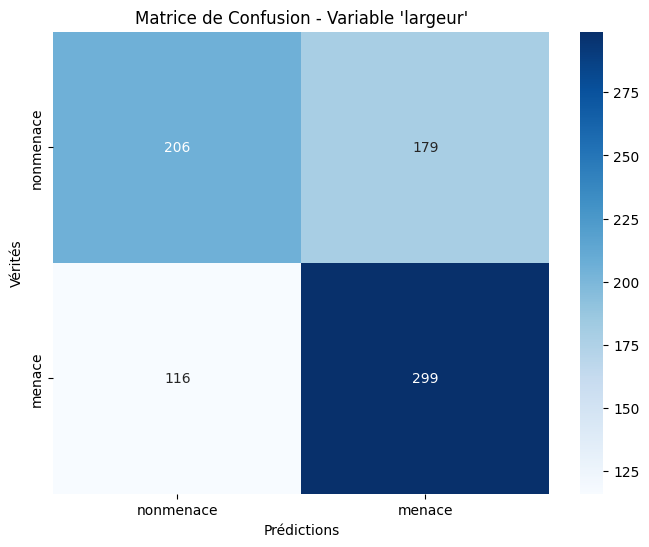

In [132]:
# Afficher le rapport de classification
print("Rapport de Classification pour la variable 'largeur':")
print(classification_report(y_ground_truth, largeur_pred, target_names=['nonmenace', 'menace']))

# Calculer la matrice de confusion
cm = confusion_matrix(y_ground_truth, largeur_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nonmenace', 'menace'], yticklabels=['nonmenace', 'menace'])
plt.title("Matrice de Confusion - Variable 'largeur'")
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

### **Arbres ?**